Part 1: Analyzing Best-Seller Trends Across Product Categories

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import math
from pathlib import Path

df = pd.read_csv(Path("C:/Users/river/OneDrive/Escritorio/Pablo/Iron Hack/Labs/lab-eda-bivariate/amz_uk_price_prediction_dataset.csv"))

category_col = "category"
bestseller_col = "isBestSeller"

df[category_col] = df[category_col].astype(str).str.strip().replace("", np.nan).fillna("Unknown")
df[bestseller_col] = (
    df[bestseller_col]
    .astype(str)
    .str.lower()
    .replace({"true": 1, "false": 0, "yes": 1, "no": 0})
    .astype(int)
)


C:\Users\river\AppData\Local\Temp\ipykernel_2640\2360978360.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"true": 1, "false": 0, "yes": 1, "no": 0})


In [11]:
crosstab_counts = pd.crosstab(df[category_col], df[bestseller_col])
print("\n Contingency Table")
print(crosstab_counts.head(10))

best_seller_ratio = (
    df.groupby(category_col)[bestseller_col]
      .mean() 
      .sort_values(ascending=False)
      .rename("best_seller_ratio")
      .reset_index()
)

print("\n Top 10 categories")
print(best_seller_ratio.head(10))


 Contingency Table
isBestSeller                           0    1
category                                     
3D Printers                          247    1
3D Printing & Scanning              4065    2
Abrasive & Finishing Products        245    5
Action Cameras                      1696    1
Adapters                             251    3
Agricultural Equipment & Supplies   8421  109
Alexa Built-In Devices               106    1
Art & Craft Supplies                 253    5
Arts & Crafts                       9319  230
Baby                               14709  341

 Top 10 categories
                         category  best_seller_ratio
0                         Grocery           0.058135
1  Smart Home Security & Lighting           0.057692
2          Health & Personal Care           0.057686
3        Mobile Phone Accessories           0.042471
4              Power & Hand Tools           0.035339
5        Billiard, Snooker & Pool           0.032129
6                    Pet Supplies    

In [9]:
ct = pd.crosstab(df[category_col], df[bestseller_col])

chi2, p, dof, expected = chi2_contingency(ct)
n = ct.to_numpy().sum()  

min_dim = min(ct.shape) - 1
cramers_v = math.sqrt(chi2 / (n * min_dim))

print("\n Chi-square Results")
print(f"- Chi statistic : {chi2:,.2f}")
print(f"- p-value        : {p:.10e}")
print(f"- Degrees of Freedom: {dof}")
print(f"- Cramér’s V     : {cramers_v:.4f}")

# Interpretación rápida según p-value
if p < 0.05:
    print( " There is statistically significant evidence of an association between category and best-seller.")
else:
    print(" No statistically significant evidence of an association between category and best-seller.")


 Chi-square Results
- Chi statistic : 36,540.20
- p-value        : 0.0000000000e+00
- Degrees of Freedom: 295
- Cramér’s V     : 0.1223
 There is statistically significant evidence of an association between category and best-seller.


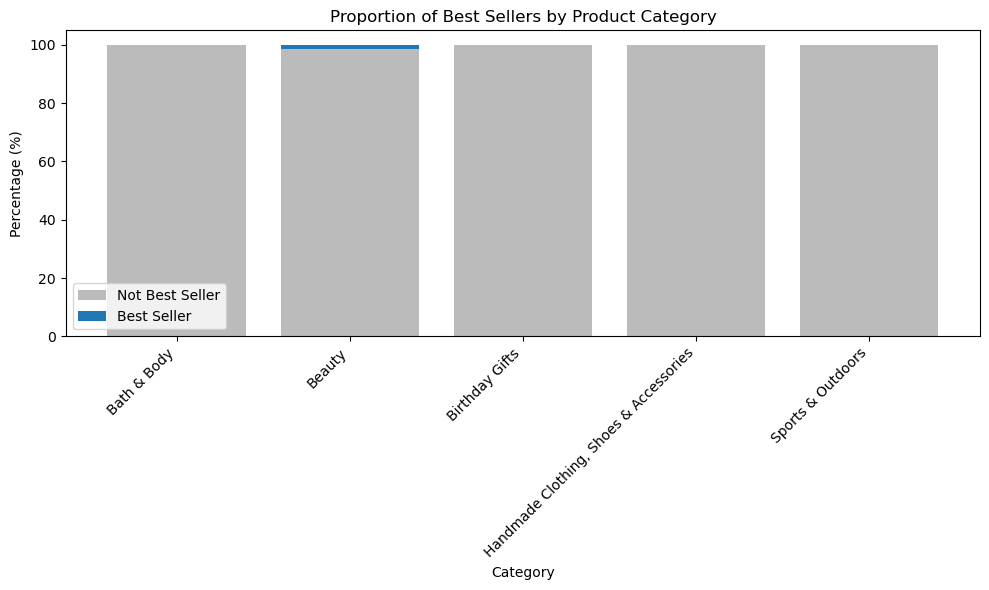

In [13]:
prop_table = (
    df.groupby(category_col)[bestseller_col]
      .value_counts(normalize=True)
      .mul(100)
      .rename("percentage")
      .reset_index()
)

top_n = 5
top_categories = df[category_col].value_counts().head(top_n).index
prop_top = prop_table[prop_table[category_col].isin(top_categories)]

plt.figure(figsize=(10, 6))

for is_best, color, label in [(0, "#BBBBBB", "Not Best Seller"), (1, "#1f77b4", "Best Seller")]:
    subset = prop_top[prop_top[bestseller_col] == is_best]
    plt.bar(
        subset[category_col],
        subset["percentage"],
        bottom=prop_top.query(f"{bestseller_col} < {is_best}")["percentage"].values if is_best == 1 else None,
        color=color,
        label=label
    )

plt.title("Proportion of Best Sellers by Product Category")
plt.xlabel("Category")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

Part 2: Exploring Product Prices and Ratings Across Categories and Brands

In [14]:
price_col = "price"

df[price_col] = pd.to_numeric(df[price_col], errors="coerce")

df_price = df.dropna(subset=[price_col]).copy()

q1 = df_price[price_col].quantile(0.25)
q3 = df_price[price_col].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_no_outliers = df_price[
    (df_price[price_col] >= lower_bound) &
    (df_price[price_col] <= upper_bound)
].copy()

print("Prices withput outliers (IQR method):")
print(f"- Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}")
print(f"- Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
print(f"- Original: {df_price.shape[0]:,}")
print(f"- Without outliers: {df_no_outliers.shape[0]:,}")

Prices withput outliers (IQR method):
- Q1: 9.99, Q3: 45.99, IQR: 36.00
- Lower bound: -44.01, Upper bound: 99.99
- Original: 2,443,651
- Without outliers: 2,115,963


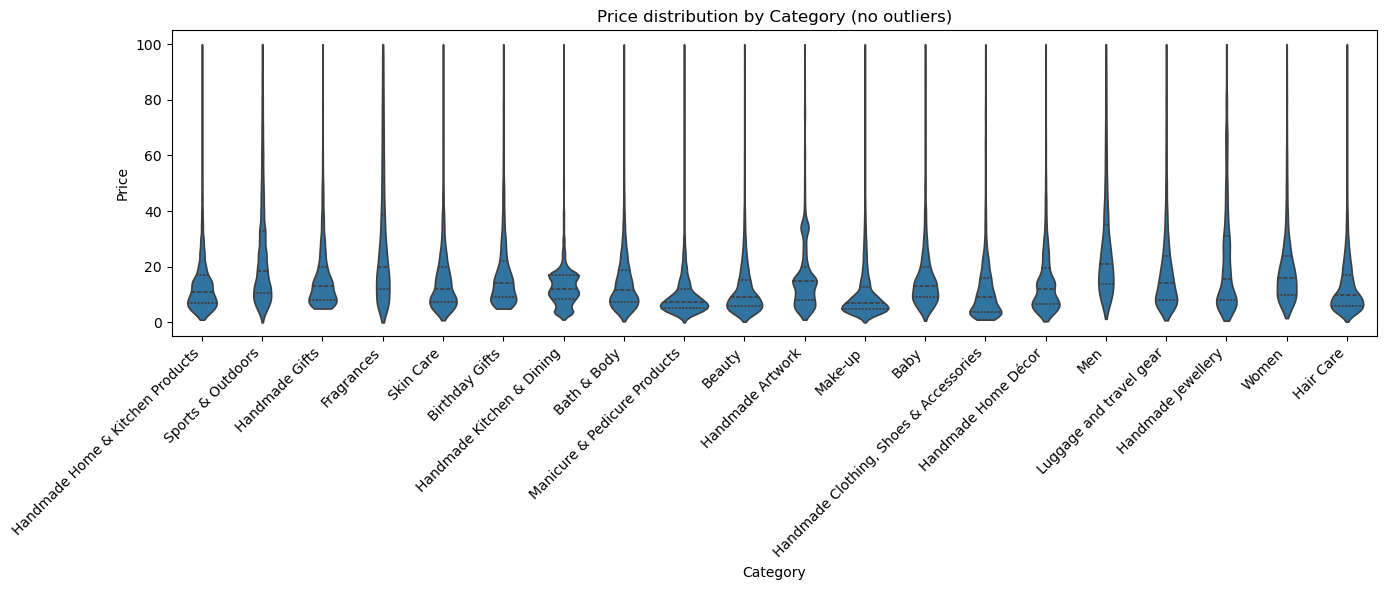


Top 10 categories:
category
Desktop PCs               74.00
Boxing Shoes              69.79
Tablets                   69.00
Graphics Cards            68.54
Motherboards              67.92
Made in Italy Handmade    64.00
Digital Frames            63.90
Streaming Clients         62.68
Golf Shoes                62.39
Ski Helmets               61.33
Name: price, dtype: float64

Category biggest median: 'Desktop PCs' (median = 74.00)


In [16]:
top20_cats = (
    df_no_outliers[category_col]
    .value_counts()
    .head(20)
    .index
)

df_violin = df_no_outliers[df_no_outliers[category_col].isin(top20_cats)].copy()

plt.figure(figsize=(14, 6))
sns.violinplot(
    data=df_violin,
    x=category_col,
    y=price_col,
    inner="quartile",
    cut=0
)
plt.xticks(rotation=45, ha="right")
plt.title("Price distribution by Category (no outliers)")
plt.xlabel("Category")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

median_price_by_cat = (
    df_no_outliers
    .groupby(category_col)[price_col]
    .median()
    .sort_values(ascending=False)
)

print("\nTop 10 categories:")
print(median_price_by_cat.head(10))
print(f"\nCategory biggest median: '{median_price_by_cat.index[0]}' (median = {median_price_by_cat.iloc[0]:.2f})")


Top 10 categories average price:
category
Motherboards         68.772432
Boxing Shoes         67.417803
Desktop PCs          66.915562
Tablets              66.552971
Graphics Cards       65.103509
Digital Frames       60.745129
Streaming Clients    60.241803
Hockey Shoes         60.094796
Computer Cases       58.339884
Skiing Poles         57.867770
Name: price, dtype: float64

Category biggest price average: 'Motherboards' (mean = 68.77)


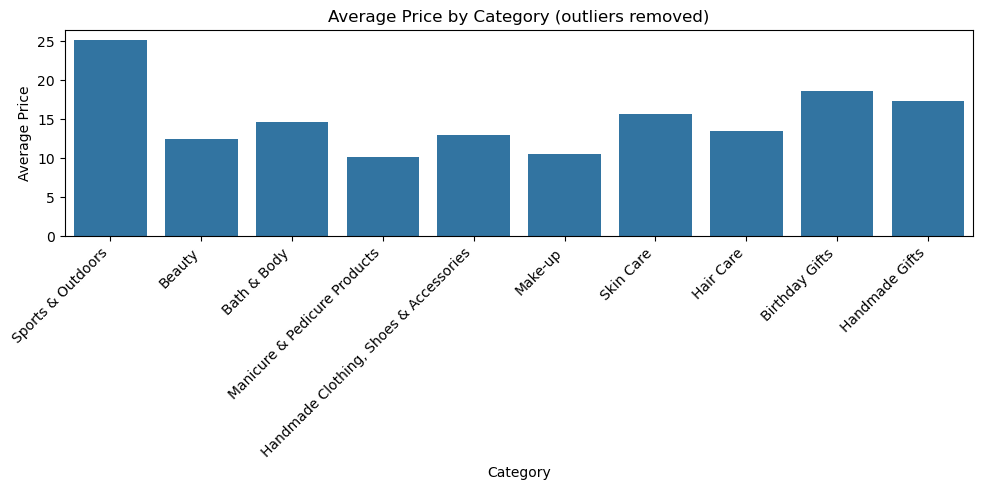

In [17]:
top10_cats_count = (
    df_no_outliers[category_col]
    .value_counts()
    .head(10)
    .index
)

mean_price_by_cat = (
    df_no_outliers
    .groupby(category_col)[price_col]
    .mean()
    .sort_values(ascending=False)
)

print("\nTop 10 categories average price:")
print(mean_price_by_cat.head(10))
print(f"\nCategory biggest price average: '{mean_price_by_cat.index[0]}' (mean = {mean_price_by_cat.iloc[0]:.2f})")

df_bar = (
    df_no_outliers[df_no_outliers[category_col].isin(top10_cats_count)]
    .groupby(category_col)[price_col]
    .mean()
    .reindex(top10_cats_count)  
)

plt.figure(figsize=(10, 5))
sns.barplot(
    x=df_bar.index,
    y=df_bar.values
)
plt.xticks(rotation=45, ha="right")
plt.title("Average Price by Category (outliers removed)")
plt.xlabel("Category")
plt.ylabel("Average Price")
plt.tight_layout()
plt.show()

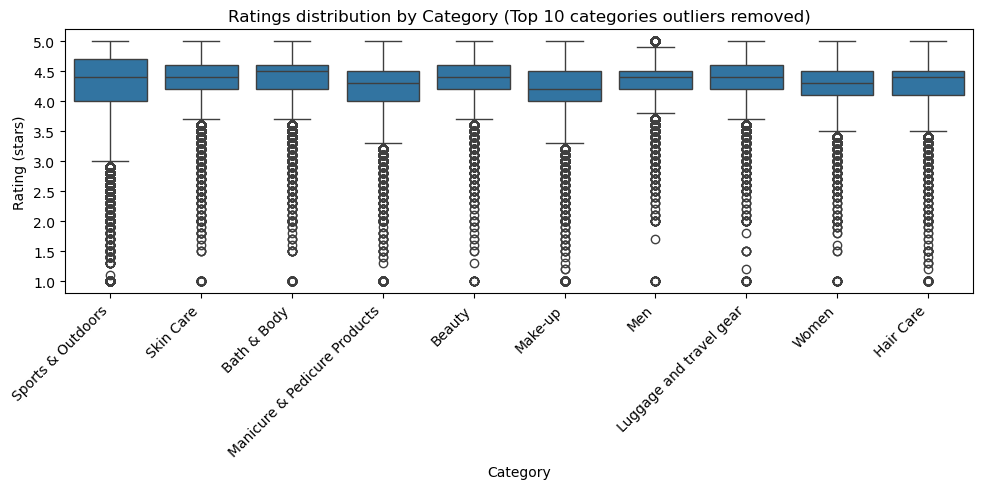


Top 10 categories rating:
category
Handmade Artwork                          5.0
Made in Italy Handmade                    5.0
Handmade Baby Products                    5.0
Handmade Clothing, Shoes & Accessories    4.9
Handmade Kitchen & Dining                 4.9
Birthday Gifts                            4.8
Handmade Home Décor                       4.8
Handmade Gifts                            4.8
Handmade Home & Kitchen Products          4.7
Computer Memory                           4.7
Name: stars, dtype: float64

Category biggest median rating: 'Handmade Artwork' (median = 5.00)


In [18]:
rating_col = "stars"

df_no_outliers[rating_col] = pd.to_numeric(df_no_outliers[rating_col], errors="coerce")
df_ratings = df_no_outliers.dropna(subset=[rating_col]).copy()

df_ratings = df_ratings[(df_ratings[rating_col] > 0) & (df_ratings[rating_col] <= 5)]

top10_cats_rating = (
    df_ratings[category_col]
    .value_counts()
    .head(10)
    .index
)

df_box = df_ratings[df_ratings[category_col].isin(top10_cats_rating)].copy()

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_box,
    x=category_col,
    y=rating_col
)
plt.xticks(rotation=45, ha="right")
plt.title("Ratings distribution by Category (Top 10 categories outliers removed)")
plt.xlabel("Category")
plt.ylabel("Rating (stars)")
plt.tight_layout()
plt.show()

median_rating_by_cat = (
    df_ratings
    .groupby(category_col)[rating_col]
    .median()
    .sort_values(ascending=False)
)

print("\nTop 10 categories rating:")
print(median_rating_by_cat.head(10))
print(f"\nCategory biggest median rating: '{median_rating_by_cat.index[0]}' (median = {median_rating_by_cat.iloc[0]:.2f})")

Part 3: Investigating the Interplay Between Product Prices and Ratings

In [21]:
from scipy.stats import pearsonr, spearmanr

price_col = "price"
rating_col = "stars"

df_corr = df_no_outliers.copy()

df_corr[price_col] = pd.to_numeric(df_corr[price_col], errors="coerce")
df_corr[rating_col] = pd.to_numeric(df_corr[rating_col], errors="coerce")

df_corr = df_corr.dropna(subset=[price_col, rating_col])
df_corr = df_corr[(df_corr[rating_col] > 0) & (df_corr[rating_col] <= 5)]

# Pearson 
pearson_r, pearson_p = pearsonr(df_corr[price_col], df_corr[rating_col])

# Spearman 
spearman_r, spearman_p = spearmanr(df_corr[price_col], df_corr[rating_col])

print("\n[Correlation Coefficients — price vs stars]")
print(f"- Pearson r  : {pearson_r:.4f}  | p-value: {pearson_p:.4e}")
print(f"- Spearman ρ : {spearman_r:.4f}  | p-value: {spearman_p:.4e}")

# Interpretation
def interpret_corr(r):
    ar = abs(r)
    if ar < 0.1:
        return "very weak / almost none"
    elif ar < 0.3:
        return "weak"
    elif ar < 0.5:
        return "moderate"
    else:
        return "strong"

print("\n Interpretation")
print(f"Pearson: {interpret_corr(pearson_r)} linear relationship.")
print(f"Spearman: {interpret_corr(spearman_r)} monotonic relationship.")

if pearson_p < 0.05:
    print(" Pearson correlation is statistically significant")
else:
    print(" Pearson correlation is not statistically significant.")

if spearman_p < 0.05:
    print(" Spearman correlation is statistically significant.")
else:
    print(" Spearman correlation is not statistically significant.")


[Correlation Coefficients — price vs stars]
- Pearson r  : 0.0067  | p-value: 1.0813e-12
- Spearman ρ : 0.0247  | p-value: 1.9778e-149

 Interpretation
Pearson: very weak / almost none linear relationship.
Spearman: very weak / almost none monotonic relationship.
 Pearson correlation is statistically significant
 Spearman correlation is statistically significant.


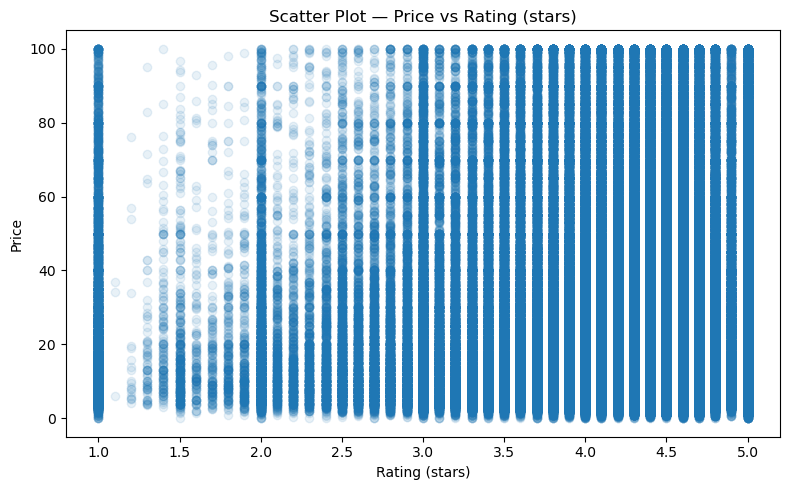

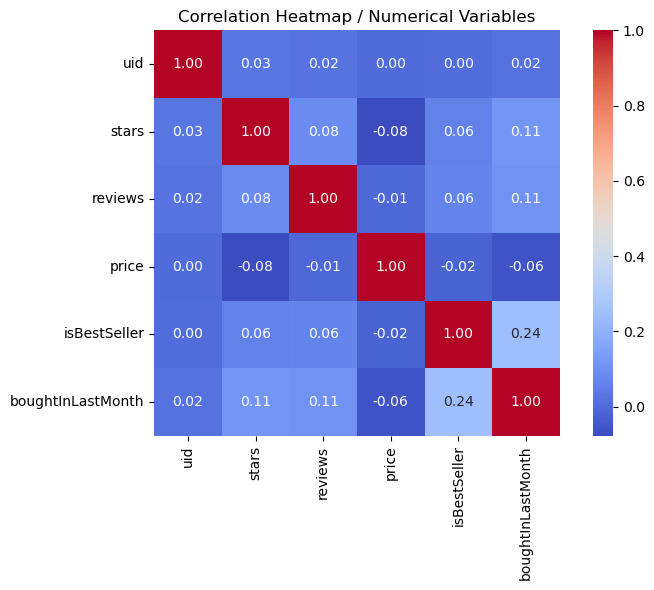

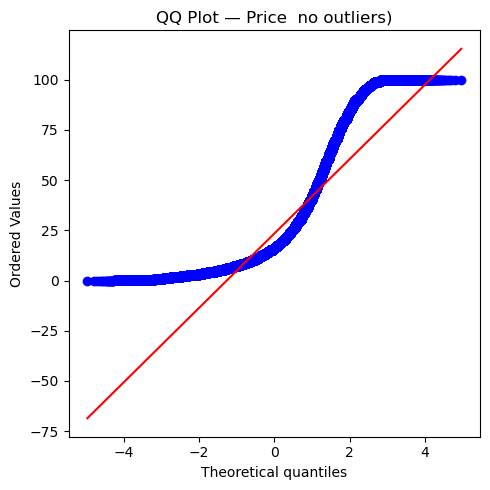

In [22]:
from scipy import stats

price_col = "price"
rating_col = "stars"

plt.figure(figsize=(8, 5))
plt.scatter(df_corr[rating_col], df_corr[price_col], alpha=0.1)
plt.title("Scatter Plot — Price vs Rating (stars)")
plt.xlabel("Rating (stars)")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

numeric_cols = df_no_outliers.select_dtypes(include=[np.number])

corr_matrix = numeric_cols.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar=True
)
plt.title("Correlation Heatmap / Numerical Variables")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
stats.probplot(df_no_outliers[price_col].dropna(), dist="norm", plot=plt)
plt.title("QQ Plot — Price  no outliers)")
plt.tight_layout()
plt.show()